Here we show how to use our models.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

# Add the relative path to the system path
sys.path.append(os.path.abspath("../train"))

from PIL import Image, ImageDraw, ImageFont

import torch as th
import torch.nn as nn
from torchvision import transforms

from ConvLSTM_model import ConvLSTM_Model

from IPython.display import Image as IPython_Image

In [2]:
# Define function to add a border and title to a PIL image
def add_border_and_title(image, title, border_size=10, font_size=20, color="white"):
    # Add border
    width, height = image.size
    new_width = width + 2 * border_size
    new_height = height + 2 * border_size + font_size + 5  # Additional space for the title
    bordered_image = Image.new("RGB", (new_width, new_height), color=color)
    bordered_image.paste(image, (border_size, border_size + font_size + 5))
    # Add title text
    draw = ImageDraw.Draw(bordered_image)
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
    draw.text(((new_width-font_size)//4,border_size), title, fill="black", font=font)
    return bordered_image

In [3]:
id_data = pd.read_csv('../data/id_df_final_10.csv')

seq_len = id_data.groupby('sequence').size()
seq_len = seq_len.to_dict()
seq_rain = id_data.groupby('sequence')['rain_category'].mean()
seq_rain = seq_rain.to_dict()

seq_df = pd.DataFrame({'seq_len': seq_len, 'seq_rain': seq_rain})

# split the sequences in train and test set (80/20)
train_seq = seq_df.sample(frac=0.8, random_state=1)
test_seq = seq_df.drop(train_seq.index)

# get the sequences of the train and test set
train_seq_idx = train_seq.index
test_seq_idx = test_seq.index
train_data = id_data[id_data['sequence'].isin(train_seq_idx)]
test_data = id_data[id_data['sequence'].isin(test_seq_idx)]

In [4]:
ids = [test_data.iloc[i]["id"] for i in range(20)]
test_images = [f"tensor_{id}.pt" for id in ids]

In [5]:
ids = [train_data.iloc[i]["id"] for i in range(10,30)]
train_images = [f"tensor_{id}.pt" for id in ids]

In [15]:
batch_size = 1
num_hidden = [64,32,32,16]
num_layers = len(num_hidden)
custom_model_config = {
    'in_shape': [1, 128, 128], # C, H, W
    'patch_size': 1,
    'filter_size': 5, 
    'stride': 2, 
    'layer_norm' : True,
    'transpose' : True,
    'bias' : False,
    'leaky_slope' : None,
    'max_pool' : True
}

if th.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

device = th.device("cuda" if th.cuda.is_available() else "cpu")

# Instantiate the model
input_dim = 3  # Assuming x_train shape is (batch_size, sequence_length, channels, height, width)
model = ConvLSTM_Model(num_layers, num_hidden, custom_model_config)

CUDA is not available.


In [16]:
# Load the model
# Load the state dictionary
#model_32_16_16_32_932271.pth using BCE loss
#model_32_16_16_32_935190.pth useless
#model_16_8_8_16_935197 works somehow
#model_16_8_8_16_935198.pth worse than 935197
#model_32_16_16_32_935194.pth uselsess
#model_16_8_8_16_935199.pth uselsess
#model_32_16_16_32_935195.pth useless
#model_64_32_32_16_940505.pth 


state_dict = th.load('../models/model_64_32_32_16_940505.pth', map_location=th.device('cpu'), weights_only=True)

# Remove `module.` prefix if it exists
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

# Load the adjusted state dict into the model
model.load_state_dict(new_state_dict, strict=True)

<All keys matched successfully>

## Check the model on the train set

In [17]:
input_row = train_images[0:10]
output_row = train_images[10:]

input_frames = [th.load(f"../data/images/{image}", weights_only=True) for image in input_row]
output_frames = [th.load(f"../data/images/{image}", weights_only=True) for image in output_row]

input_pil_frames = [transforms.ToPILImage()(frame) for frame in input_frames]
true_pil_frames = [transforms.ToPILImage()(frame) for frame in output_frames]

true_gif_list = input_pil_frames + true_pil_frames
true_gif_list[0].save('true.gif', save_all=True, append_images=true_gif_list[1:], duration=10, loop=0)

input_frames_tensor = th.stack(input_frames, dim=0)
input_frames_tensor = input_frames_tensor.unsqueeze(0)
mask_true = th.ones_like(input_frames_tensor.squeeze(0))
predicted_frames = model(input_frames_tensor, mask_true, schedule_sampling=False)
predicted_frames = predicted_frames.squeeze(0)
predicted_pil_frames = [transforms.ToPILImage()(frame) for frame in predicted_frames]
pred_gif_list = input_pil_frames + predicted_pil_frames

input_pil_frames = [
    add_border_and_title(transforms.ToPILImage()(frame), "Input Frame")
    for frame in input_frames
]
true_pil_frames = [
    add_border_and_title(transforms.ToPILImage()(frame), "Target Frame")
    for frame in output_frames
]
predicted_pil_frames = [
    add_border_and_title(transforms.ToPILImage()(frame), "Predicted Frame", color="red")
    for frame in predicted_frames
]

# List of frames as PIL Image objects
# Duration sets the display time for each frame in milliseconds
# Loop sets the number of loops. Default is 0 and means infinite
true_gif_list = input_pil_frames + true_pil_frames
true_gif_list[0].save(
    'true.gif', save_all=True, append_images=true_gif_list[1:], duration=1000, loop=0
)
pred_gif_list = input_pil_frames + predicted_pil_frames
pred_gif_list[0].save(
    'pred.gif', save_all=True, append_images=pred_gif_list[1:], duration=1000, loop=0
)

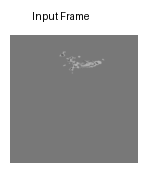

In [18]:
IPython_Image(filename='pred.gif')

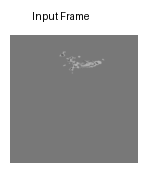

In [19]:
IPython_Image(filename='true.gif')

## Check the model on the test set

In [20]:
input_row = test_images[0:10]
output_row = test_images[10:]

input_frames = [th.load(f"../data/images/{image}", weights_only=True) for image in input_row]
output_frames = [th.load(f"../data/images/{image}", weights_only=True) for image in output_row]

input_pil_frames = [transforms.ToPILImage()(frame) for frame in input_frames]
true_pil_frames = [transforms.ToPILImage()(frame) for frame in output_frames]

true_gif_list = input_pil_frames + true_pil_frames
true_gif_list[0].save('true.gif', save_all=True, append_images=true_gif_list[1:], duration=10, loop=0)

input_frames_tensor = th.stack(input_frames, dim=0)
input_frames_tensor = input_frames_tensor.unsqueeze(0)
mask_true = th.ones(input_frames_tensor.shape)
predicted_frames = model(input_frames_tensor, mask_true)
predicted_frames = predicted_frames.squeeze(0)
predicted_pil_frames = [transforms.ToPILImage()(frame) for frame in predicted_frames]
pred_gif_list = input_pil_frames + predicted_pil_frames

input_pil_frames = [
    add_border_and_title(transforms.ToPILImage()(frame), "Input Frame")
    for frame in input_frames
]
true_pil_frames = [
    add_border_and_title(transforms.ToPILImage()(frame), "Target Frame")
    for frame in output_frames
]
predicted_pil_frames = [
    add_border_and_title(transforms.ToPILImage()(frame), "Predicted Frame", color="red")
    for frame in predicted_frames
]

# List of frames as PIL Image objects
# Duration sets the display time for each frame in milliseconds
# Loop sets the number of loops. Default is 0 and means infinite
true_gif_list = input_pil_frames + true_pil_frames
true_gif_list[0].save(
    'true.gif', save_all=True, append_images=true_gif_list[1:], duration=1000, loop=0
)
pred_gif_list = input_pil_frames + predicted_pil_frames
pred_gif_list[0].save(
    'pred.gif', save_all=True, append_images=pred_gif_list[1:], duration=1000, loop=0
)

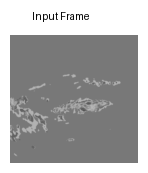

In [21]:
IPython_Image(filename='pred.gif')

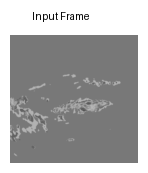

In [22]:
IPython_Image(filename='true.gif')